# **Training Word Embeddings and visualizing them**
We are going to train 64 dimensional word embeddings using a large text corpus, use them to solve analogical reasoning tasks, and then visulaize the trained embeddings using the t-SNE algorithm.

## **Define Notebook Constants**

In [77]:
base_url = '../'
dataset_url = base_url + 'Dataset/'
dictionary_size = 25000
embedding_dim = 64

## **Importing libraries**

In [78]:
import math
import joblib
import random
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = [35, 35]

## **Building our vocabulary**

In [79]:
sentences = []
sentences_file = open(dataset_url + 'sentences.txt', 'r')
while True:
    sentence = sentences_file.readline()
    if sentence == '':
        break
    else:
        sentences.append(sentence)

In [80]:
len(sentences)

3999997

In [81]:
sentences[100:120]

[' look out into the twilight sky\n',
 ' in which are vaguely the tall dark wild rooktrees with their black broad tops\n',
 ' the many gravestones\n',
 ' and the small church to the right all vague\n',
 ' semiexistent to me\n',
 ' then bertie i the word\n',
 ' rising a note\n',
 ' startles me\n',
 ' half thrills me\n',
 ' anne is at the foot of the ladder\n',
 ' up she steps shoves the door open altogether and at once begins lor\n',
 ' master bertie\n',
 ' why you look as if youd bin seen a ghost out in the graveyard\n',
 ' you do\n',
 ' gracious alive\n',
 ' the eyes of him did you ever now master bertie dont be a fool\n',
 ' what do you want i ask\n',
 ' if you want me for tea\n',
 ' im not coming\n',
 ' tell mother purchis so\n']

In [82]:
vocabulary = {}
for sentence in sentences:
    sentence = sentence[:-1]
    for word in sentence.split(' '):
        word = word.strip()
        if len(word) > 0:
            if word in vocabulary:
                vocabulary[word] += 1
            else:
                vocabulary[word] = 1

In [83]:
vocab_list = sorted([(word, vocabulary[word]) for word in vocabulary], key=lambda x: x[1], reverse=True)

In [84]:
vocab_list[:20]

[('the', 1561965),
 ('and', 946195),
 ('to', 851637),
 ('of', 848709),
 ('a', 668446),
 ('i', 484243),
 ('in', 468653),
 ('he', 434727),
 ('was', 396759),
 ('that', 383186),
 ('it', 341810),
 ('his', 335750),
 ('you', 333165),
 ('her', 292304),
 ('with', 267797),
 ('had', 262003),
 ('as', 254349),
 ('for', 245261),
 ('she', 240711),
 ('not', 219948)]

In [85]:
vocab_list_trimmed = vocab_list[:dictionary_size]

In [86]:
vocabulary_trimmed = {}
for word, freq in vocab_list_trimmed:
    vocabulary_trimmed[word] = freq

In [87]:
word_to_index = {}
index_to_word = {}
for i, word in enumerate(sorted(vocabulary_trimmed.keys())):
    word_to_index[word] = i
    index_to_word[i] = word

## **Prepare Context-Target pairs**

In [12]:
context_target_pairs = []
for i, sentence in enumerate(sentences):
    words = list(filter(lambda x: len(x) > 0, map(str.strip, sentence.split(' '))))
    x = 0
    while x < len(words):
        if (x + 4 < len(words) and words[x] in word_to_index and words[x + 1] in word_to_index 
            and words[x + 2] in word_to_index and words[x + 3] in word_to_index 
            and words[x + 4] in word_to_index):
            context_target_pairs.append(((word_to_index[words[x]], word_to_index[words[x + 1]], 
                                    word_to_index[words[x + 2]], word_to_index[words[x + 3]]), 
                                    word_to_index[words[x + 4]]))
        x += 1

In [13]:
len(context_target_pairs)

15458366

In [14]:
context_target_pairs[1000:1020]

[((6804, 984, 9792, 22457), 20305),
 ((984, 9792, 22457, 20305), 11461),
 ((9792, 22457, 20305, 11461), 233),
 ((22457, 20305, 11461, 233), 4977),
 ((20305, 11461, 233, 4977), 24378),
 ((11461, 233, 4977, 24378), 2105),
 ((984, 22133, 4360, 13786), 12460),
 ((22133, 4360, 13786, 12460), 10824),
 ((4360, 13786, 12460, 10824), 10306),
 ((13786, 12460, 10824, 10306), 15543),
 ((12460, 10824, 10306, 15543), 14881),
 ((10824, 10306, 15543, 14881), 1313),
 ((10306, 15543, 14881, 1313), 984),
 ((15543, 14881, 1313, 984), 22147),
 ((14881, 1313, 984, 22147), 11189),
 ((1313, 984, 22147, 11189), 24080),
 ((984, 22147, 11189, 24080), 13150),
 ((22147, 11189, 24080, 13150), 6804),
 ((11189, 24080, 13150, 6804), 984),
 ((24080, 13150, 6804, 984), 24150)]

## **Define Model**

In [91]:
def get_model():
    inputs = tf.keras.layers.Input(shape=(4,), dtype='float32')
    embeddings = tf.keras.layers.Embedding(dictionary_size, embedding_dim, trainable=True)(inputs)
    flatten = tf.keras.layers.Flatten()(embeddings)
    outputs = tf.keras.layers.Dense(dictionary_size, activation='softmax')(flatten)
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [92]:
embedding_model = get_model()

In [93]:
embedding_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 4, 64)             1600000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 25000)             6425000   
Total params: 8,025,000
Trainable params: 8,025,000
Non-trainable params: 0
_________________________________________________________________


## **Fit model to dataset**

In [18]:
def get_batch(start, stop, context_target_pairs):
    length = stop - start + 1
    X = np.zeros((length, 4))
    Y = np.zeros((length, dictionary_size))
    for i in range(start, stop + 1):
        c_ind, t_ind = (
            (
                context_target_pairs[i][0][0], 
                context_target_pairs[i][0][1], 
                context_target_pairs[i][0][2], 
                context_target_pairs[i][0][3]
            ), 
            context_target_pairs[i][1]
            )
        X[i - start, :] = np.array(c_ind)
        Y[i - start, t_ind] = 1
    return X, Y

In [19]:
def batchLoader(files, batch_size):
    L = len(files)
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < L:
            limit = min(batch_end, L - 1)
            yield get_batch(batch_start, limit, files)  
            batch_start += batch_size   
            batch_end += batch_size

In [20]:
random.shuffle(context_target_pairs)
context_target_pairs_test = context_target_pairs[:30000]
context_target_pairs_train = context_target_pairs[30000:]

In [94]:
checkpoint_filepath = base_url + 'Embedding/embedding_weights.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, 
    monitor='loss',
    save_weights_only=True,
    save_best_only=True, 
    mode='min'
)

In [22]:
embedding_model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"],
)

In [23]:
embedding_model.fit_generator(batchLoader(context_target_pairs_train, 512), 
        steps_per_epoch=len(context_target_pairs_train) // 512 ,epochs=10, 
        callbacks=[model_checkpoint_callback])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/10
30133/30133 [==============================] - 1942s 64ms/step - loss: 6.2732 - accuracy: 0.1213
Epoch 2/10
30133/30133 [==============================] - 1920s 64ms/step - loss: 5.6104 - accuracy: 0.1556
Epoch 3/10
30133/30133 [==============================] - 1918s 64ms/step - loss: 5.4421 - accuracy: 0.1649
Epoch 4/10
30133/30133 [==============================] - 1898s 63ms/step - loss: 5.3424 - accuracy: 0.1701
Epoch 5/10
30133/30133 [==============================] - 1904s 63ms/step - loss: 5.2715 - accuracy: 0.1738
Epoch 6/10
30133/30133 [==============================] - 1901s 63ms/step - loss: 5.2167 - accuracy: 0.1766
Epoch 7/10
30133/30133 [==============================] - 1907s 63ms/step - loss: 5.1723 - accuracy: 0.1787
Epoch 8/10
30133/30133 [==============================] - 1902s 63ms/step - loss: 5.1352 - accuracy: 0.1805
Epoch 9/10
30133/30133 [==============================] - 19

## **Evaluating model**

In [95]:
embedding_model.load_weights(checkpoint_filepath)

In [23]:
loss = 0
correct = 0
total = 0
inputs = np.array([context_target_pairs_test[i][0] for i in range(len(context_target_pairs_test))])
outputs = embedding_model.predict(inputs)
for i in range(len(context_target_pairs_test)):
    loss += -math.log(outputs[i, context_target_pairs_test[i][1]])
    prediction = np.argmax(outputs[i, :])
    if prediction == context_target_pairs_test[i][1]:
        correct += 1
    total += 1

print("Average Loss =", loss / total)
print("Accuracy =", correct / total)

Average Loss = 5.017210946713853
Accuracy = 0.18566666666666667


## **Saving Embeddings**

In [ ]:
joblib.dump(embedding_mat, base_url + 'Embedding/embeddings.pkl')
joblib.dump(word_to_index, base_url + 'Embedding/word_to_index_map.pkl')
joblib.dump(index_to_word, base_url + 'Embedding/index_to_word_map.pkl')

['drive/My Drive/Colab Notebooks/Embeddings/Embedding/index_to_word_map.pkl']

## **Testing embeddings by trying to solve analogical reasoning tasks**

In [96]:
embedding_mat = np.array(embedding_model.layers[1].get_weights())[0]
embedding_mat.shape

(25000, 64)

In [97]:
def cosine_similarity(vec1, vec2):
    return np.sum(vec1 * vec2) / ((np.sum(vec1 ** 2) ** 0.5) * (np.sum(vec2 ** 2) ** 0.5))

In [98]:
def squared_diff(vec1, vec2):
    return -np.sum((vec1 - vec2) ** 2)

In [99]:
def analogical_reasoning(w1, w2, w3):
    i1, i2, i3 = word_to_index[w1], word_to_index[w2], word_to_index[w3]
    e1, e2, e3 = embedding_mat[i1, :], embedding_mat[i2, :], embedding_mat[i3, :]
    top_5 = []
    for i in range(dictionary_size):
        if i not in [i1, i2, i3]:
            sq_diff = squared_diff(embedding_mat[i, :], e3 - e1 + e2)
            top_5.append((sq_diff, i))
            top_5 = sorted(top_5, key=lambda x: x[0], reverse=True)
            if len(top_5) > 5:
                top_5.pop()
    return [(index_to_word[top_5[i][1]], top_5[i][0]) for i in range(len(top_5))]

In [100]:
analogical_reasoning('king', 'queen', 'men')

[('women', -8.192905),
 ('ladies', -8.783694),
 ('children', -9.343114),
 ('gentlemen', -10.360927),
 ('persons', -10.883252)]

In [101]:
analogical_reasoning('tall', 'taller', 'large')

[('larger', -13.435591),
 ('heavier', -15.472463),
 ('smaller', -15.926177),
 ('greater', -16.481712),
 ('shorter', -16.888102)]

In [102]:
analogical_reasoning('good', 'better', 'bad')

[('worse', -13.028595),
 ('wiser', -14.4294),
 ('happier', -16.276688),
 ('safer', -17.131199),
 ('harder', -17.346956)]

## **Visualizing the trained embeddings using the t-SNE algorithm**

In [37]:
embedding_map2D = TSNE(n_components=2, perplexity=22, learning_rate=250, n_iter=10000, 
                    verbose=1).fit_transform(embedding_mat)

[t-SNE] Computing 67 nearest neighbors...
[t-SNE] Indexed 25000 samples in 0.221s...
[t-SNE] Computed neighbors for 25000 samples in 92.882s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional probabilities for sa

In [128]:
def distance(x1, y1, x2, y2):
        return ((y2 - y1) ** 2 + (x2 - x1) ** 2) ** 0.5

def plot_words(words, rad1=2, rad2=5):    
    ind = [word_to_index[word] for word in words]
    fig, ax = plt.subplots()
    ant_pts_dict = {}
    pts_dict = {}
    for i in ind:
        x, y = embedding_map2D[i, 0], embedding_map2D[i, 1]
        close = True
        while close:
            x += ((-1) ** (random.randint(1, 2))) * 0.8 * rad1 * random.random()
            y += ((-1) ** (random.randint(1, 2))) * 0.8 * rad1 * random.random()
            curr_close = False
            for x2, y2 in pts_dict:
                if distance(x, y, x2, y2) < rad1:
                    curr_close = True
                    break
            close = curr_close
        ax.scatter(x, y, s=250)
        x1, y1 = x, y
        close = True
        while close:
            x1 += ((-1) ** (random.randint(1, 2))) * 0.7 * rad2 * random.random()
            y1 += ((-1) ** (random.randint(1, 2))) * 0.7 * rad2 * random.random()
            curr_close = False
            for x2, y2 in ant_pts_dict:
                if distance(x1, y1, x2, y2) < rad2:
                    curr_close = True
                    break
            close = curr_close
        ax.annotate(index_to_word[i], (x, y), (x1, y1), fontsize=25)
        ant_pts_dict[(x1, y1)]  = True
    plt.show()

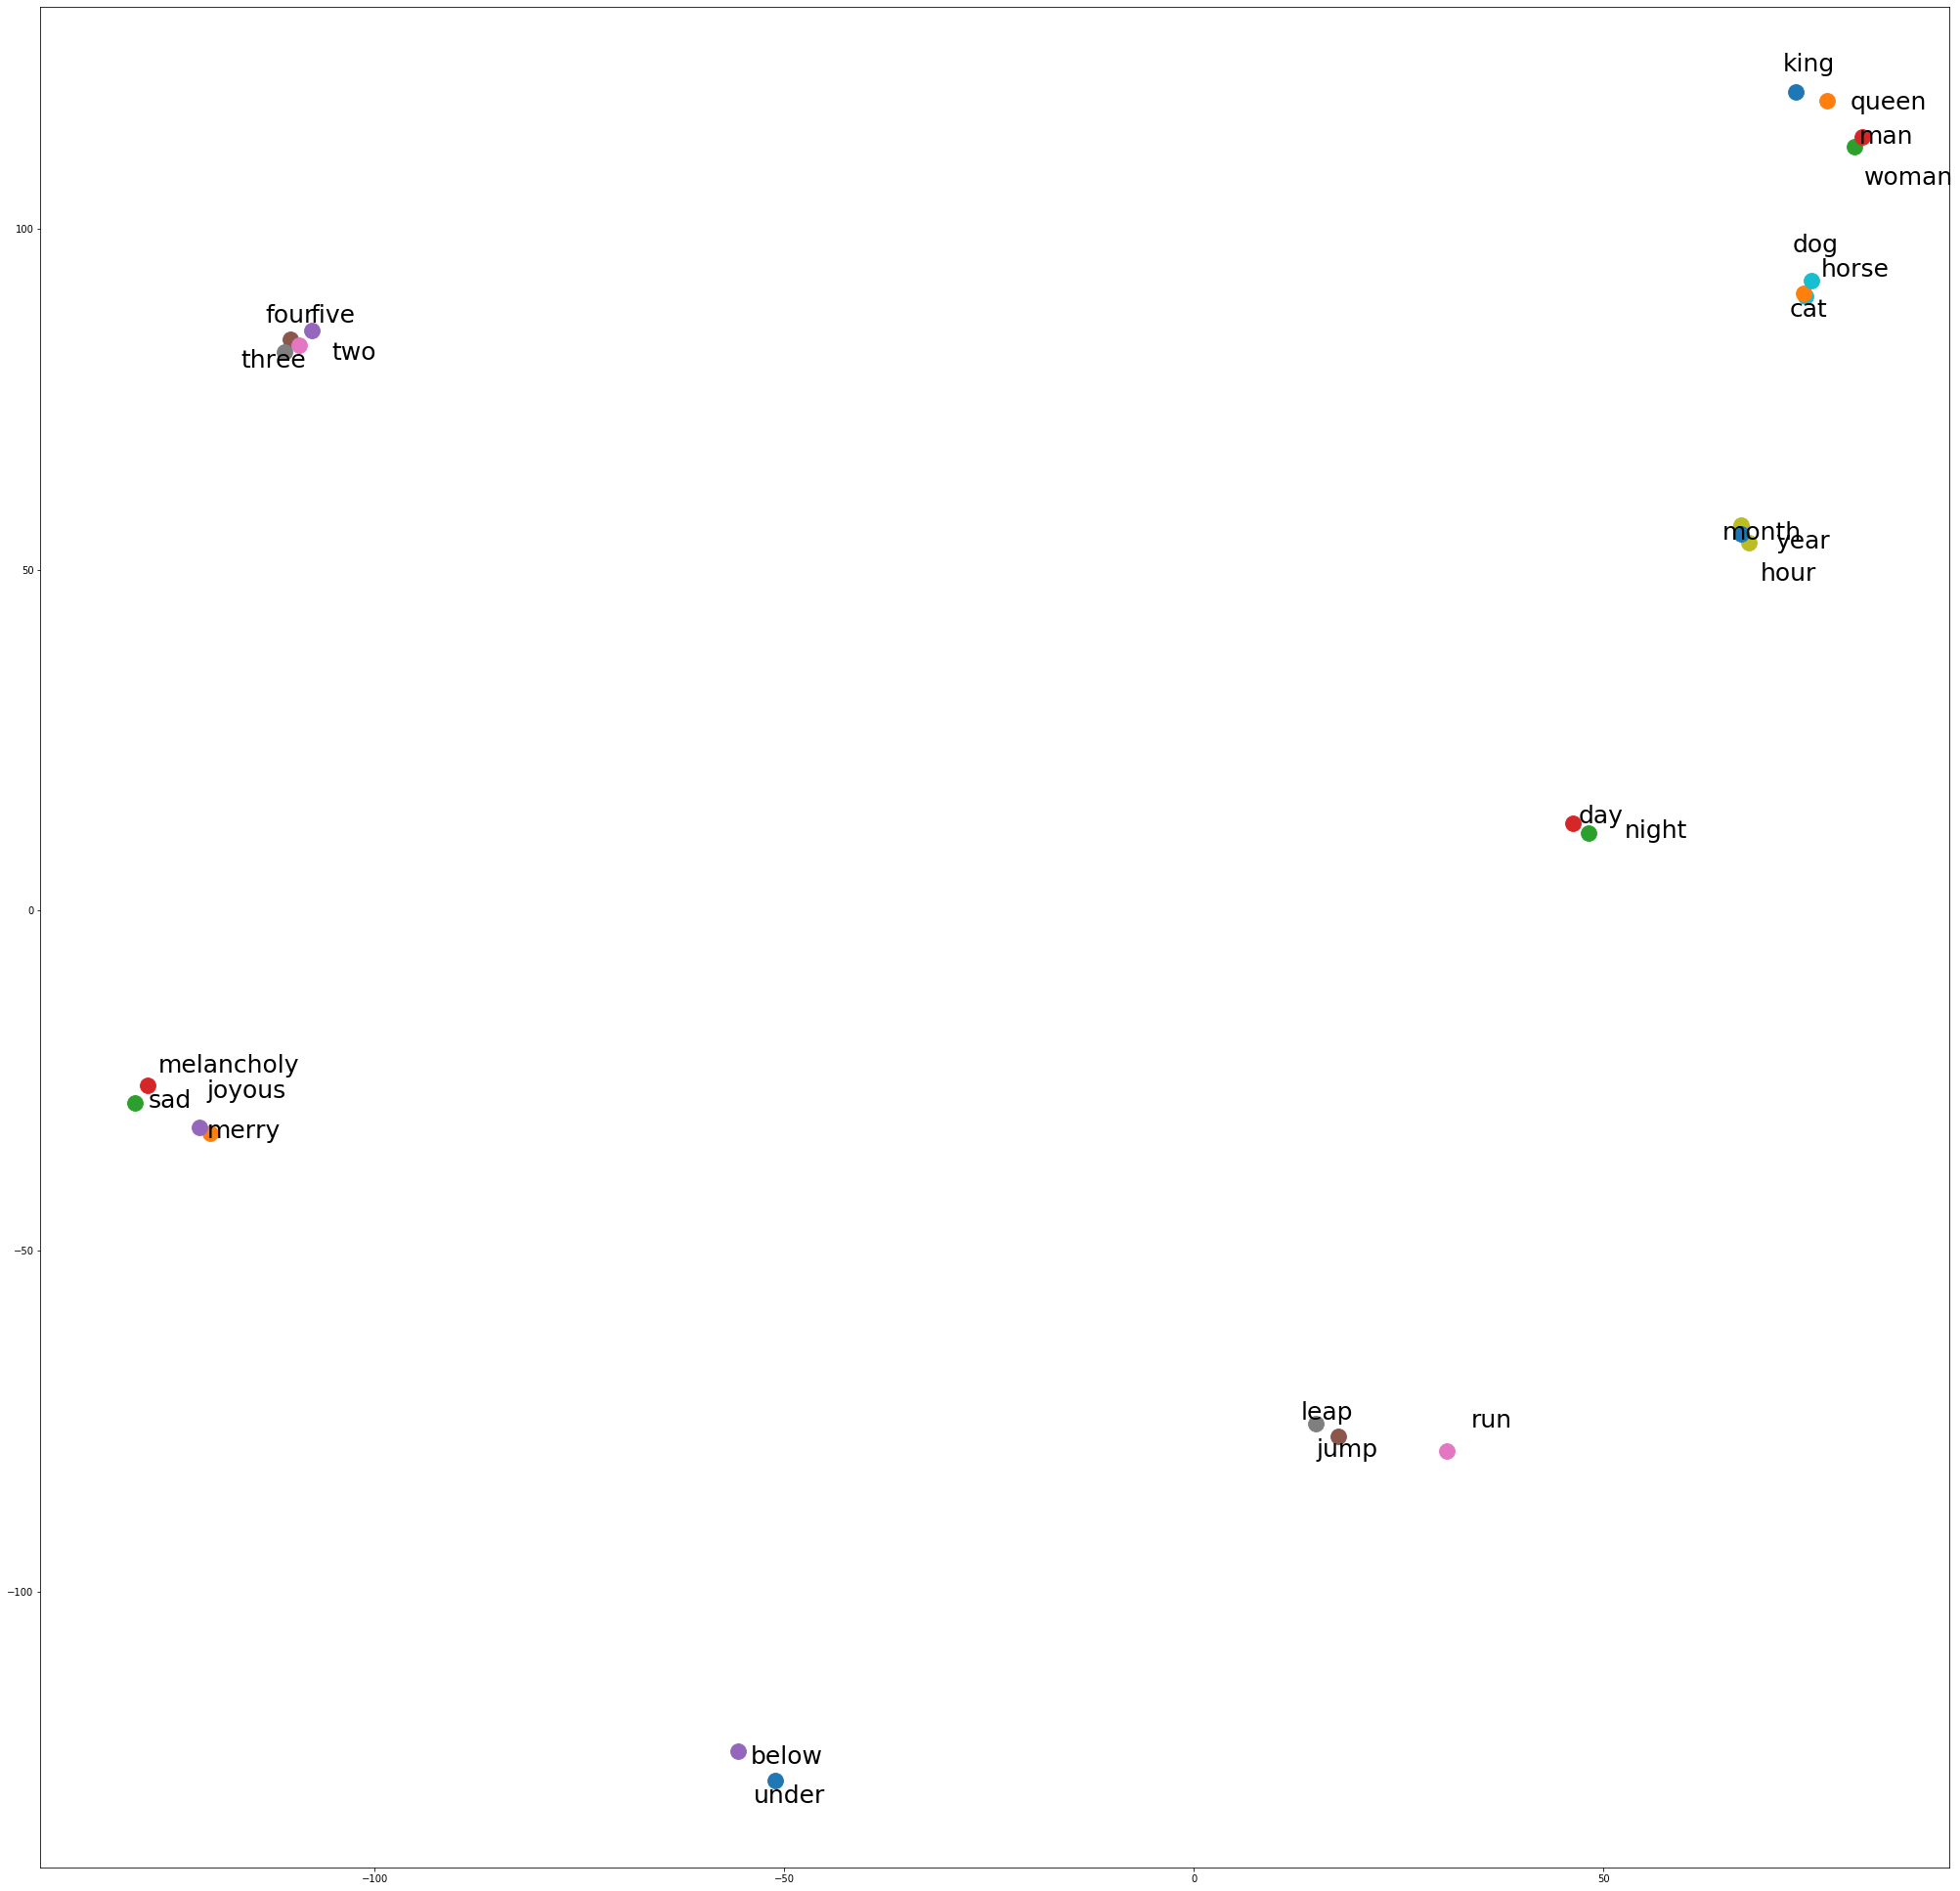

In [130]:
plot_words(
    [
        'king', 
        'queen', 
        'man', 
        'woman', 
        'five', 
        'four', 
        'two', 
        'three', 
        'month', 
        'cat', 
        'under', 
        'horse', 
        'day', 
        'night', 
        'below', 
        'jump', 
        'run', 
        'leap', 
        'year', 
        'dog', 
        'hour', 
        'merry', 
        'sad', 
        'melancholy', 
        'joyous', 
    ]
)